# Certification of Robustness using Intervals

In this notebook we will look at using interval bound propagation (IBP) to assess a neural network's certified robustness. 

To do so we will use a datapoint's interval, also called box, representation. This captures the minimum and maximum values that a feature can take. 

Then we propagate the interval through the neural network and, by using interval arithmetic on the neural network components we can determine if a datapoint could have its class changed. 

The interval domain has the great advantage that it is *fast*. However, this speed comes at the expense of precision - we aggressively over-approximate in the forward pass and so we can often only certify a small subset of the data which is safe. More formally, this technique is sound but incomplete.

We can see an example of how imprecision arises by looking at a neural network layer that causes a rotation: 

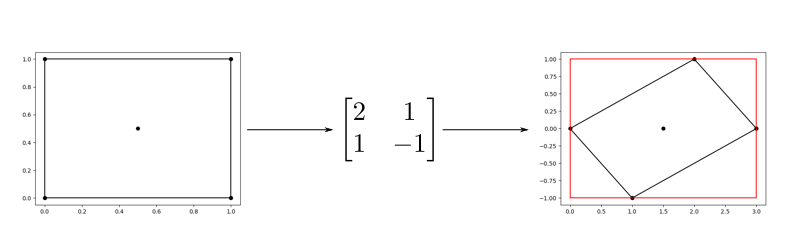

The exact operation when multiplied with the weight matrix should lead to the rotated rectangle. However, in the interval domain we only consider the maximums and minimums of each feature, thus resulting in the larger red rectangle which contains many excess regions.

Let's see how this does in practice!

In [1]:
import torch
import torch.optim as optim
import numpy as np

from torch import nn
from sklearn.utils import shuffle

from art.estimators.certification import interval
from art.utils import load_mnist, preprocess, to_categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device ', device)

Using device  cuda:0


In [2]:
# We make an example pytorch classifier

class MNISTModel(torch.nn.Module):
    """
    The base model which we will then convert into one using different abstract domains
    """

    def __init__(self, number_of_classes: int):
        super(MNISTModel, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(1, 1))

        self.conv_2 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=32,
                                      kernel_size=(4, 4),
                                      stride=(2, 2))

        self.conv_3 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(1, 1))

        self.conv_4 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=64,
                                      kernel_size=(4, 4),
                                      stride=(2, 2))

        self.fc1 = torch.nn.Linear(in_features=1024, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=512)
        self.fc_out = torch.nn.Linear(in_features=512, out_features=number_of_classes)

        self.relu = torch.nn.ReLU()

    def forward(self, x: "torch.Tensor") -> "torch.Tensor":

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = self.relu(self.conv_4(x))

        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        return self.fc_out(x)

In [3]:
model = MNISTModel(number_of_classes=10)
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_test = np.squeeze(x_test)
x_test = np.expand_dims(x_test, axis=1)
y_test = np.argmax(y_test, axis=1)

x_train = np.squeeze(x_train)
x_train = np.expand_dims(x_train, axis=1)
y_train = np.argmax(y_train, axis=1)

In [4]:
# train the model normally

def standard_train(model, opt, criterion, x, y, bsize=32, epochs=5):
    num_of_batches = int(len(x) / bsize)
    for epoch in range(epochs):
        x, y = shuffle(x, y)
        loss_list = []
        for bnum in range(num_of_batches):
            x_batch = np.copy(x[bnum * bsize:(bnum + 1) * bsize])
            y_batch = np.copy(y[bnum * bsize:(bnum + 1) * bsize])

            x_batch = torch.from_numpy(x_batch).float().to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)

            # zero the parameter gradients
            opt.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_list.append(loss.data.cpu())
            loss.backward()
            opt.step()
        print('End of epoch {} loss {}'.format(epoch, np.mean(loss_list)))
    return model

model = standard_train(model=model,
                       opt=opt,
                       criterion=criterion,
                       x=x_train,
                       y=y_train)

End of epoch 0 loss 0.2816831171512604
End of epoch 1 loss 0.07683608680963516
End of epoch 2 loss 0.051124896854162216
End of epoch 3 loss 0.03650381416082382
End of epoch 4 loss 0.027725202962756157


In [5]:
# lets now get the predicions for the MNIST test set and see how well our model is doing.
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)

Test acc:  98.72


In [6]:
# But how robust are these predictions? 
# We can now examine this neural network's certified robustness. 
# We pass it into PyTorchIBPClassifier. We will get a print out showing which 
# neural network layers have been registered. There will also be a 
# warning to tell us that PytorchInterval currently infers a reshape when 
# a neural network goes from using convolutional to dense layers. 
# This will cover the majority of use cases, however, if not then the 
# certification layers in art.estimators.certification.interval.interval.py 
# can be used to directly build a certified model structure.

interval_model = interval.PyTorchIBPClassifier(model=model, 
                                               clip_values=(0, 1), 
                                               loss=nn.CrossEntropyLoss(), 
                                               input_shape=(1, 28, 28), 
                                               nb_classes=10)

registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
Inferred reshape on op num 8


In [7]:
bound = 0.01
num_certified = 0
num_correct = 0

# Use the test data to check its certified robustness.
original_x = np.copy(x_test)

# Regular accuracy on normal data
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test))

# Here we will manually convert the data into its interval representation
upper_bounds = np.clip(np.expand_dims(x_test, axis=1) + bound, 0, 1)
lower_bounds = np.clip(np.expand_dims(x_test, axis=1) - bound, 0, 1)

interval_x = np.concatenate([lower_bounds, upper_bounds], axis=1)

with torch.no_grad():
    interval_preds = interval_model.predict_intervals(x=interval_x,
                                                      is_interval=True,
                                                      batch_size=32)
    cert_results = interval_model.certify(preds=interval_preds, labels=y_test)
    print('Certified score ', np.mean(cert_results))

Test acc:  98.72
Certified score  0.0


We can see that this is very low! Much lower than the certification you could get with using Zonotopes for example (see the deepz notebook for comparison). So why use intervals?

- Computationally it is very fast: only x2 overhead compared to normal classification as each datapoint is represented by upper and lower bounds. 
- By comparison Zonotopes can grow (particularly in terms of memory) hundreds of times larger. 
- We can improve the performance by orders of magnitude if we combine it with methods like certified adversarial training.

None the less, we can use the interval domain to certify for smaller regions of inputs (or also for lower dimensional inputs). Let's now use it to certify against a pixel brightening attack

In [8]:
bound = 0.005
int_x = np.expand_dims(x_test, axis=1)

# pixels of a certain brighness can be raised to the maximum value.
upper_bounds = np.where(int_x > 1 - bound, 1, int_x)
interval_x = np.concatenate([int_x, upper_bounds], axis=1)

with torch.no_grad():
    interval_preds = interval_model.predict_intervals(x=interval_x,
                                                      is_interval=True,
                                                      batch_size=32)
    cert_results = interval_model.certify(preds=interval_preds, labels=y_test)
    print('Certified score ', np.mean(cert_results))

Certified score  0.4766
